# Features selection

Feature selection refers to algorithms that can help us narrow down our **feature set** to a smaller set of important features, where importance here refers to the strength of the relationship between the feature and the target. A more important feature is one that ultimately can influence the model's prediction more. In this assignment, you will write a program that imploments filter-based feature selection.

**Filter-based selection** refer to methods we can use to identify pairs of features with a high correlation and remove one of them from the data. One way we can measure the degree to which two features are associated is using **correlation**, but correlation (**pearson's correlation coefficient**, to be specific) measures the strength of **linear association** meaning that when correlation is high between two features (close to 1 or -1) then their scatter plot looks like a straight line. If instead of a straight line the scatter plot followed a curved line, we need to use other measures such as **ranked correlation** or **mutual information**.

In the following example, we generate two features $X$ and $Y$ which are related to each other based on a polynomial (curve-like) equation with some added noise.

Standard Deviation of Y = 1.20


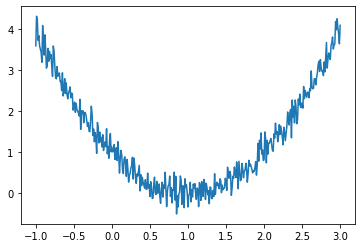

In [1]:
import numpy as np
import pandas as pd

X = np.linspace(start = -1, stop = 3, num = 401, endpoint = True)
Y = X**2 - 2*X + 1 # Y is a polynomial function of X
print("Standard Deviation of Y = {:0.2f}".format(np.std(Y)))

noise_var = 0.2
noise = np.random.normal(0, noise_var, len(X))
Y += noise # add noise

import matplotlib.pyplot as plt
plt.plot(X, Y)
plt.show()

Of course we can can just plot the features against each other and see how they're related, but imagine having to do this for every pair of some 20 features. So instead we want to rely on some metric to do this, so that we can later simply filter out redundant features based on correlation or some other metric. Let's see what the correlation coefficient is.

In [2]:
corr = np.corrcoef(X, Y)[0, 1]
print("Correlation between X and Y is {:0.2f}".format(corr))

Correlation between X and Y is 0.01


As we can see, the correlation is close to zero, and if we had not plotted $X$ against $Y$, we would have been led to believe that there is no association between them, but let's now use mutual information to capture the stregth of their association.

In [3]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency = c_xy)
    return mi

print("Mutual information = {:0.2f}".format(calc_MI(X, Y, 20)))

Mutual information = 1.45


Now we return to the `retail-churn.csv` dataset that we worked previously

In [4]:
churn = pd.read_csv('retail-churn.csv')
churn.head()

,UserId,Age,Address,Column 0,TransactionId,Timestamp,ItemId,Quantity,Value
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


Run the following steps to pre-process the data:

1. Convert `Timestamp` into a `datetime` column and extract two new columns: `DoW` is the day of the week and `Month` is the calendar month.

In [5]:
churn['Timestamp'] = pd.to_datetime(churn['Timestamp'])
churn_df = pd.DataFrame(churn)
DoW = churn['Timestamp'].dt.dayofweek
Month = churn['Timestamp'].dt.month
churn_df['DoW'] = DoW
churn_df['Month'] = Month
churn_df.dtypes

UserId                    int64
Age                      object
Address                  object
Column 0                  int64
TransactionId             int64
Timestamp        datetime64[ns]
ItemId                  float64
Quantity                  int64
Value                     int64
DoW                       int64
Month                     int64
dtype: object

2. One-hot encode `Address`, `DoW` and `Month`. Your pre-processed data should only contain the features created above as well as `Quantity` and `Value`.

In [6]:
from sklearn.preprocessing import OneHotEncoder

cat_col = ['Address','DoW','Month']
churn_df[cat_col] = churn_df[cat_col].astype('category')
churn_cat = churn_df.select_dtypes('category').copy() # only select columns that have type 'category'
onehot = OneHotEncoder(sparse = False) # initialize one-hot-encoder
onehot.fit(churn_cat)
col_names = onehot.get_feature_names(churn_cat.columns) # this allows us to properly name columns
churn_onehot =  pd.DataFrame(onehot.transform(churn_cat), columns = col_names)
churn_onehot['Quantity'] = churn_df['Quantity'].astype('float64')
churn_onehot['Value'] = churn_df['Value'].astype('float64')
churn_onehot.head()

,Address_A,Address_B,Address_C,Address_D,Address_E,Address_F,Address_G,Address_H,DoW_0,DoW_1,...,DoW_3,DoW_4,DoW_5,DoW_6,Month_1,Month_2,Month_11,Month_12,Quantity,Value
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,37.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,17.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,23.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,41.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,288.0


3. Now write a function called `reduce_dimensionality`. The input to the function is the pre-processed data. Here's what your function does:
  - It finds the mutual information between all possibles pairs of features in the data. 
  - If the mutual information is less than some value `threshold` (make it an argument to the function), then it moves on to the next pair.
  - If the mutual information is greater than `thershold`, it drops one of the two features (doesn't matter which) from the data. 

  So the above function should return the data, but with only a subset of the original features so that no two features share a mutual information higher than `threshold`.

In [7]:
# The function will return a subset of the original features share a mutual information less than threshold
# Command: reduce_dimensionality (some_df, threshold) 
# Where some_df is one hot coded pre-processed data and threshold is an arbitrary value

def reduce_dimensionality(some_df, threshold):
    drop_col = []
    for i in range(1,len(some_df.columns)-1,1):
        for j in range(i,len(some_df.columns)-1,1):
            mi = calc_MI(some_df[some_df.columns[i-1]],some_df[some_df.columns[j]] , 20)
            if mi > threshold:
                drop_col.append(some_df.columns[i-1])
                break
    some_df_reduce = some_df.drop(drop_col, axis = 1)
    return some_df_reduce
                    

4. When threshold is set to 0, most columns drop because mi values are greater than 0

In [8]:
reduce_dimensionality(churn_onehot, 0)

,Quantity,Value
0,1.0,37.0
1,1.0,17.0
2,1.0,23.0
3,1.0,41.0
4,8.0,288.0
...,...,...
252199,2.0,138.0
252200,1.0,96.0
252201,1.0,89.0
252202,1.0,108.0


5. If `threshold` is set to 1, all columns remain because mi values are less than 1

In [9]:
reduce_dimensionality(churn_onehot, 1)

,Address_A,Address_B,Address_C,Address_D,Address_E,Address_F,Address_G,Address_H,DoW_0,DoW_1,...,DoW_3,DoW_4,DoW_5,DoW_6,Month_1,Month_2,Month_11,Month_12,Quantity,Value
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,37.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,17.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,23.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,41.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,288.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252199,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,138.0
252200,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,96.0
252201,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,89.0
252202,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,108.0


6. Same with when `theshold` = 0.5

In [10]:
reduce_dimensionality(churn_onehot, 0.5)

,Address_A,Address_B,Address_C,Address_D,Address_E,Address_F,Address_G,Address_H,DoW_0,DoW_1,...,DoW_3,DoW_4,DoW_5,DoW_6,Month_1,Month_2,Month_11,Month_12,Quantity,Value
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,37.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,17.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,23.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,41.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,288.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252199,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,138.0
252200,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,96.0
252201,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,89.0
252202,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,108.0


7. Modify your function so that you can choose between mutual information and correlation coefficient. 

In [11]:
# This function will return a subset of the original features share a mutual information or correlation less than threshold
# Command: reduce_dimensionality (mode, some_df, threshold) 
# Where: mode is either "mutual" for mutual information or correlation if mode is not "mutual"
# some_df is one hot coded pre-processed data 
# and threshold is an arbitrary value
def modified_reduce_dimensionality(mode, some_df, threshold):
    drop_col = []
    for i in range(1,len(some_df.columns)-1,1):
        for j in range(i,len(some_df.columns)-1,1):
            if mode == "mutual":
                mi = calc_MI(some_df[some_df.columns[i-1]],some_df[some_df.columns[j]] , 20)
                if mi > threshold:
                    drop_col.append(some_df.columns[i-1])
                    break
            else:
                corr = np.corrcoef(some_df[some_df.columns[i-1]],some_df[some_df.columns[j]])[0, 1]
                if corr > threshold:
                    drop_col.append(some_df.columns[i-1])
                    break
    some_df_reduce = some_df.drop(drop_col, axis = 1)
    return some_df_reduce


8. Run your function on the pre-processed data, using correlation coefficient instead of mutual information this time. Use the same threshold. 

In [12]:
modified_reduce_dimensionality("corr",churn_onehot, 0)

,Month_1,Month_2,Quantity,Value
0,0.0,0.0,1.0,37.0
1,0.0,0.0,1.0,17.0
2,0.0,0.0,1.0,23.0
3,0.0,0.0,1.0,41.0
4,0.0,0.0,8.0,288.0
...,...,...,...,...
252199,0.0,1.0,2.0,138.0
252200,0.0,1.0,1.0,96.0
252201,0.0,1.0,1.0,89.0
252202,0.0,1.0,1.0,108.0


For threshold = 0.5 or 1, both methods yield the same result
For threshold = 0, the mutual information dropped the most features

In [13]:
print('Number of columns different between correlation and mutual info method:')
print('Threshold = 0: ' + str(len(modified_reduce_dimensionality("corr",churn_onehot, 0).columns) - len(modified_reduce_dimensionality("mutual",churn_onehot, 0).columns)))
print('Threshold = 0.5: ' + str(len(modified_reduce_dimensionality("corr",churn_onehot, 0.5).columns) - len(modified_reduce_dimensionality("mutual",churn_onehot, 0.5).columns)))
print('Threshold = 1: ' + str(len(modified_reduce_dimensionality("corr",churn_onehot, 1).columns) - len(modified_reduce_dimensionality("mutual",churn_onehot, 1).columns)))

Number of columns different between correlation and mutual info method:
Threshold = 0: 2
Threshold = 0.5: 0
Threshold = 1: 0
